# Spectral Analysis

In [1]:
# load all libraries
import numpy as np
import matplotlib.pyplot as plt
import mne
import random
%matplotlib inline

## Time vs phase-locked

Let's first have a function that generates sine waves for us with specified parameters.

In [2]:
# 1s, 1000 Hz
t = np.linspace(0, 1, 1000)

# generate a sine wave ... default 1 Hz
def make_sine(f = 1, t = np.linspace(0, 1, 1000), p = 0):
    sine_wave = np.sin(2 * np.pi * f * t + p)
    return sine_wave

Now a function that takes the sign and embeds it into a longer trial

In [3]:
def make_trial(totdur = 3, startosc = 1, freqosci = 1, oscidur = 1, phase = 0):
    ttot = np.linspace(0, totdur, 1000 * totdur) #3 sec epoch
    tosci = np.linspace(0, oscidur, 1000 * oscidur)
    sine_wave = make_sine(f = freqosci, t= tosci, p = phase)
    trial = np.zeros(len(ttot))
    # find beginning of event
    ind1 = np.argmin(np.abs(ttot-startosc))
    ind2 = ind1 + len(tosci)
    
    assert ind2 <= len(ttot), 'The embedded response cannot be longer than the trial'

    trial[ind1:ind2] = trial[ind1:ind2] + sine_wave
    return  ttot, trial
    

Following responses are time-locked

Text(0.5, 0, 'Time (s)')

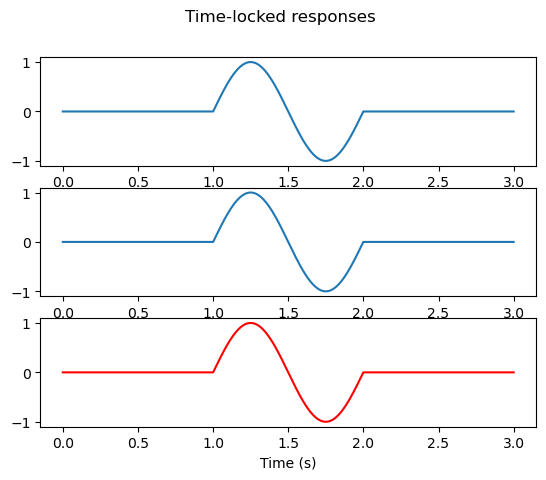

In [4]:
time, trial1 = make_trial()
time, trial2 = make_trial()

fig, axs = plt.subplots(3)
fig.suptitle('Time-locked responses')
axs[0].plot(time, trial1)
axs[1].plot(time, trial2)
axs[2].plot(time, (trial1 + trial2)/2, 'red')
plt.ylim(-1.1,1.1)
plt.xlabel('Time (s)')


Response that is not time locked.

Text(0.5, 0, 'Time (s)')

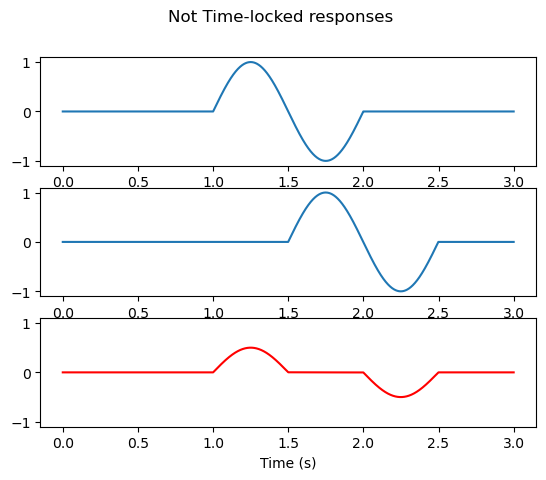

In [5]:
time, trial1 = make_trial()
time, trial2 = make_trial(startosc = 1.5)

fig, axs = plt.subplots(3)
fig.suptitle('Not Time-locked responses')
axs[0].plot(time, trial1)
axs[1].plot(time, trial2)
axs[2].plot(time, (trial1 + trial2)/2, 'red')
plt.ylim(-1.1,1.1)
plt.xlabel('Time (s)')

Responses that are time, but not phase locked

Text(0.5, 0, 'Time (s)')

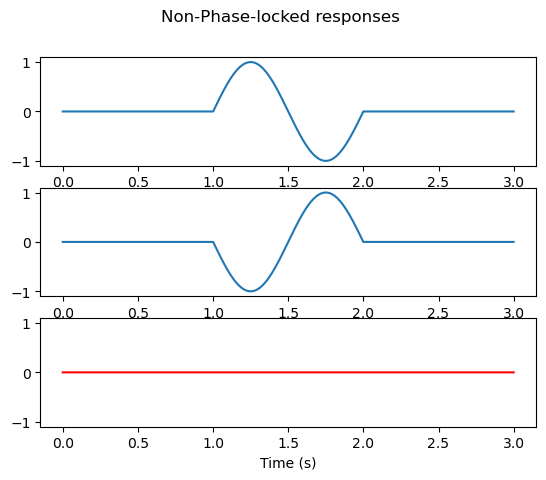

In [6]:
time, trial1 = make_trial()
time, trial2 = make_trial(phase = np.pi)

fig, axs = plt.subplots(3)
fig.suptitle('Non-Phase-locked responses')
axs[0].plot(time, trial1)
axs[1].plot(time, trial2)
axs[2].plot(time, (trial1 + trial2)/2, 'red')
plt.ylim(-1.1,1.1)
plt.xlabel('Time (s)')

# Oscillations and averaging

First let's make some epochs with 10 Hz oscillations embedded in noise.

In [50]:
#PARAMETERS YOU CAN PLAY WITH#
ntrials = 100
samprate = 1000
duration = 3 #s
SNR = 1/10
jitterrange = [.5, 1.5]
phaserange = [-np.pi, np.pi]
##################

dataNoJitter = np.random.uniform(-1, 1, (ntrials, 1, samprate * duration)) # generate noise, 1 channel
dataRandJitter = np.random.uniform(-1, 1, (ntrials, 1, samprate * duration))
dataRandPhase = np.random.uniform(-1, 1, (ntrials, 1, samprate * duration))

info = mne.create_info(ch_names=['Channel1'], sfreq=samprate, ch_types=['eeg'])

for ii in range(ntrials):
    #starts strictly at 1s
    ttot, trial = make_trial(totdur = duration, startosc = 1, freqosci = 10, oscidur = 1, phase = 0)
    trial = trial.reshape((1, -1)) # reshape trial to match dataNoJitter
    dataNoJitter[ii,:,:] = dataNoJitter[ii,:,:] + trial * SNR
    
    #Jitter between .5 to 1.5
    tmp = np.round(random.uniform(jitterrange[0], jitterrange[1]), 3)
    ttot, trial = make_trial(totdur = duration, startosc = tmp, freqosci = 10, oscidur = 1, phase = 0)
    trial = trial.reshape((1, -1)) # reshape trial to match dataNoJitter
    dataRandJitter[ii,:,:] = dataRandJitter[ii,:,:] + trial  * SNR
    
    #Jitter between -pi to pi
    tmp = np.round(random.uniform(phaserange[0], phaserange[1]), 3)
    ttot, trial = make_trial(totdur = duration, startosc = 1, freqosci = 10, oscidur = 1, phase = tmp)
    trial = trial.reshape((1, -1)) # reshape trial to match dataNoJitter
    dataRandPhase[ii,:,:] = dataRandPhase[ii,:,:] + trial  * SNR
    

epochsNoJitter = mne.EpochsArray(dataNoJitter, info)
epochsRandJitter = mne.EpochsArray(dataRandJitter, info)
epochsRandPhase = mne.EpochsArray(dataRandPhase, info)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


Plot a few trials. Can you see the oscillation with naked eye?

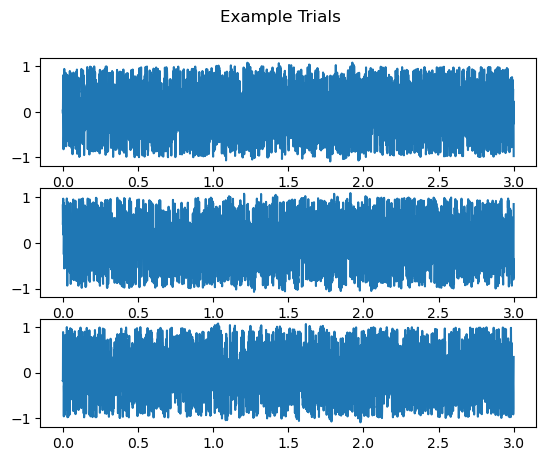

In [47]:
fig, axs = plt.subplots(3)
fig.suptitle('Example Trials')
axs[0].plot(ttot, dataNoJitter[10,:,:].reshape(samprate * duration,))
axs[1].plot(ttot, dataRandJitter[10,:,:].reshape(samprate * duration,))
axs[2].plot(ttot, dataRandPhase[10,:,:].reshape(samprate * duration,))

Now we average (=evoked responses!) the trials & take a look at the responses.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


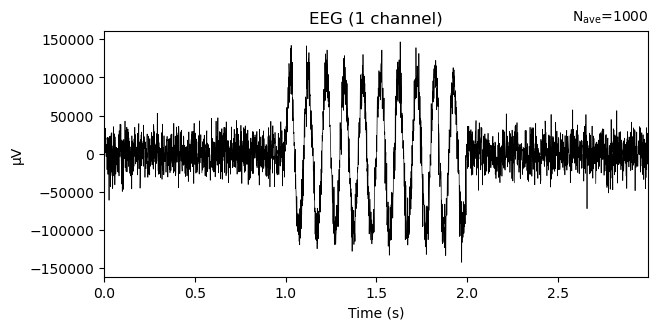

Need more than one channel to make topography for eeg. Disabling interactivity.


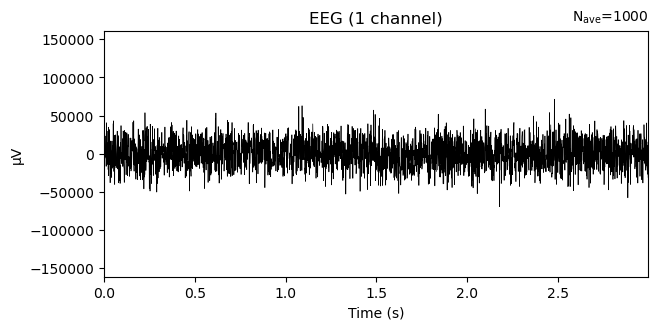

Need more than one channel to make topography for eeg. Disabling interactivity.


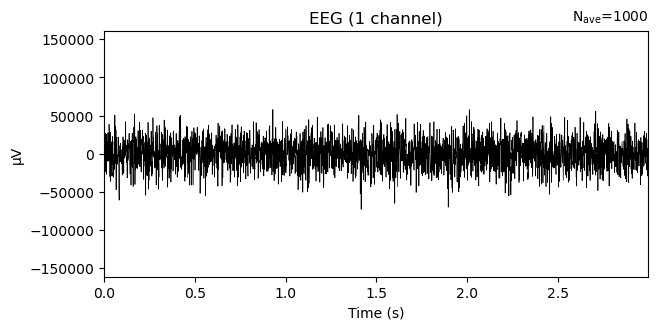

In [48]:
erpNoJitter = epochsNoJitter.average()
erpRandJitter = epochsRandJitter.average()
erpRandPhase = epochsRandPhase.average()

ylimits = np.abs(erpNoJitter.get_data()).max() * 1.1

erpNoJitter.plot(ylim = dict(eeg=[-ylimits * 1e6, ylimits * 1e6]));
erpRandJitter.plot(ylim = dict(eeg=[-ylimits * 1e6, ylimits * 1e6]));
erpRandPhase.plot(ylim = dict(eeg=[-ylimits * 1e6, ylimits * 1e6]));


Can you see a clear evoked response?

If you want play around with the parameters marked above, before creating the trials. For example the trial number or SNR.

# Evoked versus Induced

The avering procedure above shows that an oscillatory response buried in noise can be revealed by averaging when it is time- and phase-locked. But not so much when there is e.g. a lot of jitter. [Side Note: This emphasizes the absolute importance of precise timing when doing electrophysiological experiments!]

Of course this can also be shown in the time-frequency domain.

In [55]:
freqs = np.arange(2, 21, 1)
n_cycles = freqs / 2 # defines the length of the sliding time-window in units of cycles; here fix 500 ms
time_bandwidth = 2.0 #determines the number of DPSS tapers to be used; N = time_bandwidth - 1

tfr_evoked_NJ =  mne.time_frequency.tfr_multitaper(
    erpNoJitter, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_evoked_RJ =  mne.time_frequency.tfr_multitaper(
    erpRandJitter, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_evoked_RP =  mne.time_frequency.tfr_multitaper(
    erpRandPhase, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


No baseline correction applied


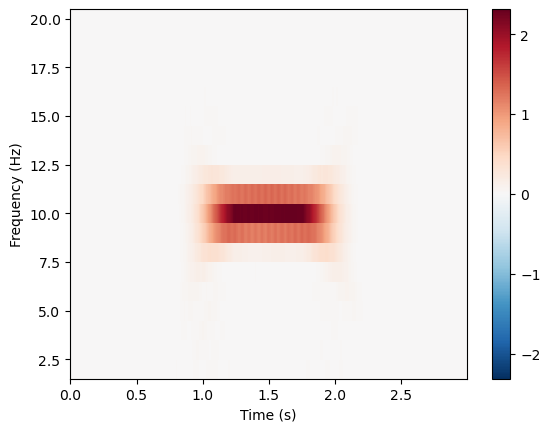

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


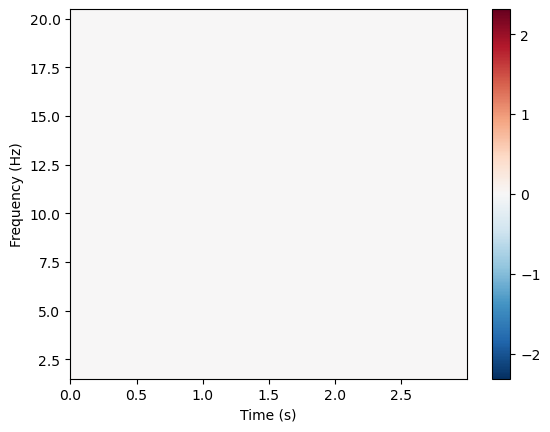

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


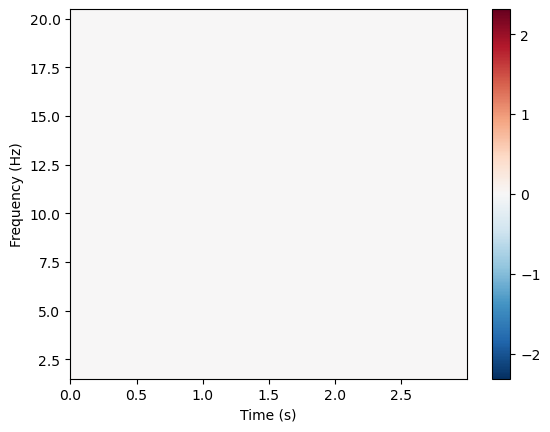

[<Figure size 640x480 with 2 Axes>]

In [66]:
zlimval = np.abs(tfr_evoked_NJ.data).max()

tfr_evoked_NJ.plot(vmin = -zlimval, vmax = zlimval)
tfr_evoked_RJ.plot(vmin = -zlimval, vmax = zlimval)
tfr_evoked_RP.plot(vmin = -zlimval, vmax = zlimval)

Not surprisingly, the time-frequency depiction shows the same as the time-series: i.e. once you have strong jitter in time or phase, then your oscillation “disappears“.

An alternative is to perform your time-frequency analysis on each single trial and then average these representations. Let's give it a shot.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


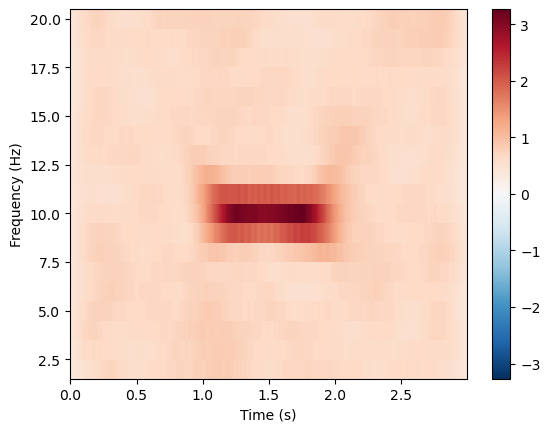

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


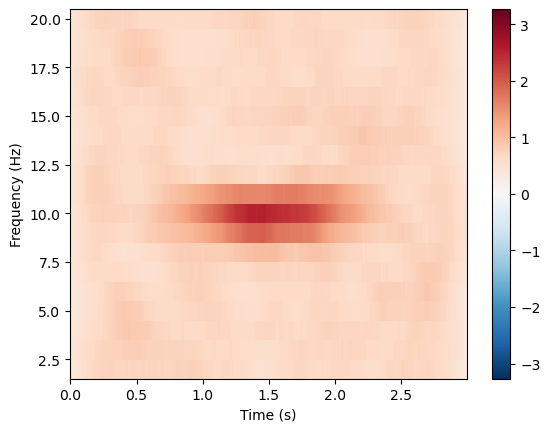

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


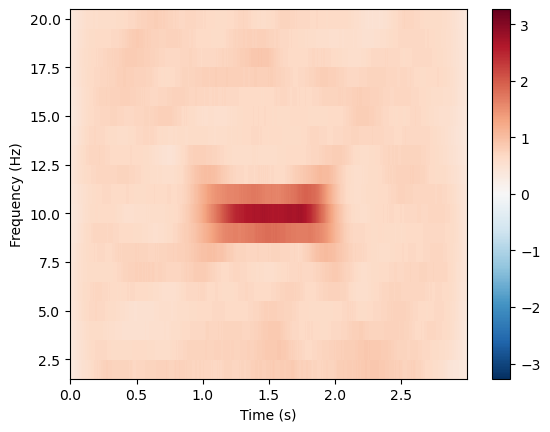

[<Figure size 640x480 with 2 Axes>]

In [68]:
# we will use the same parameters for the FFT

tfr_induced_NJ =  mne.time_frequency.tfr_multitaper(
    epochsNoJitter, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_induced_RJ =  mne.time_frequency.tfr_multitaper(
    epochsRandJitter, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

tfr_induced_RP =  mne.time_frequency.tfr_multitaper(
    epochsRandPhase, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'eeg',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

zlimval = np.abs(tfr_induced_NJ.data).max()

tfr_induced_NJ.plot(vmin = -zlimval, vmax = zlimval)
tfr_induced_RJ.plot(vmin = -zlimval, vmax = zlimval)
tfr_induced_RP.plot(vmin = -zlimval, vmax = zlimval)

What do you notice?

## How about some real data? 

In [72]:
#let's use da data-set and snipptest of code provided by MNE Python with some somatisensory stimulation
#see: https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html
from mne.datasets import somato

data_path = somato.data_path()
subject = "01"
task = "somato"
raw_fname = data_path / f"sub-{subject}" / "meg" / f"sub-{subject}_task-{task}_meg.fif"

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
# crop and resample just to reduce computation time
#raw.crop(120, 360).load_data().resample(200)
raw.load_data().resample(200)
events = mne.find_events(raw, stim_channel="STI 014")

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg="grad", eeg=False, eog=True, stim=False)

# Construct Epochs
event_id, tmin, tmax = 1, -1.0, 3.0
baseline = (None, 0)
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    reject=dict(grad=4000e-13, eog=350e-6),
    preload=True,
)

Opening raw data file /Users/b1019548/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
111 events found
Event IDs: [1]
111 events found
Event IDs: [1]
111 events found
Event IDs: [1]
Not setting metadata
111 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 111 events and 801 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped


In [75]:
freqs = np.arange(2, 31, 1)
n_cycles = freqs / 2 
time_bandwidth = 2.0

tfr =  mne.time_frequency.tfr_multitaper(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = 4,
    verbose=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 204 out of 204 | elapsed:   14.5s finished


Let's average the output over all sensors. What do you notice?

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
No baseline correction applied
No baseline correction applied


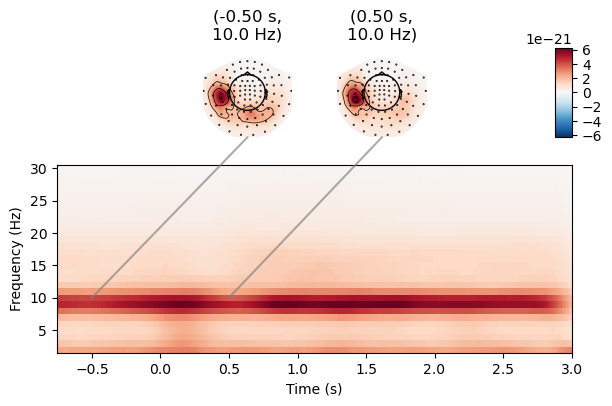

In [90]:
tfr.plot_joint(tmin = -.75,
               timefreqs=[(-0.5, 10), (0.5, 10)]);


Now we will add some baseline normalization.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne/baseline.py:122: RuntimeWarning: divide by zero encountered in divide
  d /= m


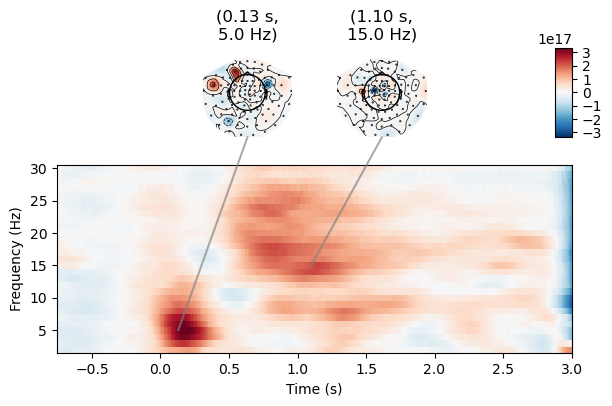

In [97]:
tfr.plot_joint(tmin = -.75,
               baseline=(-0.500,-0.100),
               mode = 'percent',
               timefreqs=[(0.13, 5), (1.1, 15)]);

#TOPO LOOKS MESSY ... PROBABLY BECAUSE BASELINE APPLIED BEFORE COMBINING

In [100]:
dir(tfr)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_check_compat',
 '_data',
 '_decim',
 '_handle_tmin_tmax',
 '_onselect',
 '_pick_drop_channels',
 '_pick_projs',
 '_plot',
 '_raw_times',
 '_set_times',
 '_size',
 '_times_readonly',
 '_update_first_last',
 'add_channels',
 'add_reference_channels',
 'apply_baseline',
 'baseline',
 'ch_names',
 'comment',
 'compensation_grade',
 'copy',
 'crop',
 'data',
 'decimate',
 'drop_channels',
 'freqs',
 'get_channel_types',
 'info',
 'method',
 'nave',
 'pick',
 'pick_cha

In [102]:
tfr.ch_names

['MEG 0113',
 'MEG 0112',
 'MEG 0122',
 'MEG 0123',
 'MEG 0132',
 'MEG 0133',
 'MEG 0143',
 'MEG 0142',
 'MEG 0213',
 'MEG 0212',
 'MEG 0222',
 'MEG 0223',
 'MEG 0232',
 'MEG 0233',
 'MEG 0243',
 'MEG 0242',
 'MEG 0313',
 'MEG 0312',
 'MEG 0322',
 'MEG 0323',
 'MEG 0333',
 'MEG 0332',
 'MEG 0343',
 'MEG 0342',
 'MEG 0413',
 'MEG 0412',
 'MEG 0422',
 'MEG 0423',
 'MEG 0432',
 'MEG 0433',
 'MEG 0443',
 'MEG 0442',
 'MEG 0513',
 'MEG 0512',
 'MEG 0523',
 'MEG 0522',
 'MEG 0532',
 'MEG 0533',
 'MEG 0542',
 'MEG 0543',
 'MEG 0613',
 'MEG 0612',
 'MEG 0622',
 'MEG 0623',
 'MEG 0633',
 'MEG 0632',
 'MEG 0642',
 'MEG 0643',
 'MEG 0713',
 'MEG 0712',
 'MEG 0723',
 'MEG 0722',
 'MEG 0733',
 'MEG 0732',
 'MEG 0743',
 'MEG 0742',
 'MEG 0813',
 'MEG 0812',
 'MEG 0822',
 'MEG 0823',
 'MEG 0913',
 'MEG 0912',
 'MEG 0923',
 'MEG 0922',
 'MEG 0932',
 'MEG 0933',
 'MEG 0942',
 'MEG 0943',
 'MEG 1013',
 'MEG 1012',
 'MEG 1023',
 'MEG 1022',
 'MEG 1032',
 'MEG 1033',
 'MEG 1043',
 'MEG 1042',
 'MEG 1112',